# RBF-Networks

## Training data

In [1]:
p = 120

In [99]:
import numpy as np


def sample_instance(negative_instance=True, sigma=np.sqrt(0.1)):
    if np.random.rand() <= 0.5:
        if negative_instance:
            mean = (0, 1)
        else:
            mean = (0, 0)
    else:
        if negative_instance:
            mean = (1, 0)
        else:
            mean = (1, 1)
    return np.random.normal(mean, sigma)

In [58]:
X_neg = np.array([sample_instance(negative_instance=True) for i in range(60)])
X_pos = np.array([sample_instance(negative_instance=False) for i in range(60)])

In [59]:
X = np.vstack((X_neg, X_pos)).T
y = np.hstack((np.zeros(60), np.ones(60)))

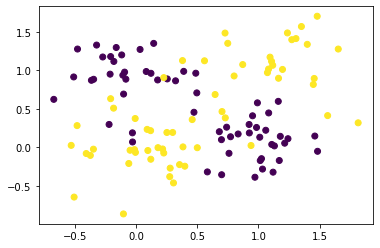

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(x=X[0], y=X[1], c=y)

## $k$NN Classifier

In [122]:
def classify_knn(x, k, X=X, y=y):
    distances = np.linalg.norm((X.T - x), axis=1)
    sorting = np.argsort(distances)
    knns = sorting[:k]
    y_knns = y[knns]
    y_pred = np.mean(y_knns)
    return y_pred

In [123]:
classify_knn((0.5, 0.5), k=5)

0.6

In [124]:
def draw_knn_contour(k, X=X, y=y):    
    xs = np.linspace(-0.5, 1.5)
    ys = np.linspace(-0.5, 1.5)

    z = []
    for i in range(len(xs)):
        for j in range(len(ys)):
            z.append(classify_knn((xs[i], ys[j]), k, X=X, y=y))

    z = np.array(z).reshape((len(xs), len(ys)))
    zs = (z <= 0.5).astype(int)
    fig, ax = plt.subplots()

    ax.contourf(xs, ys, zs)

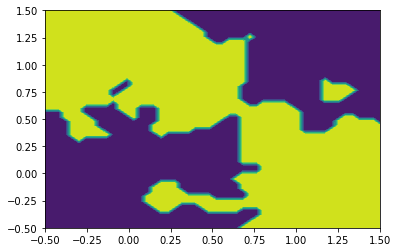

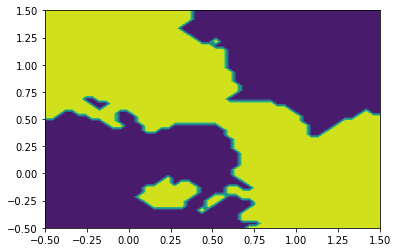

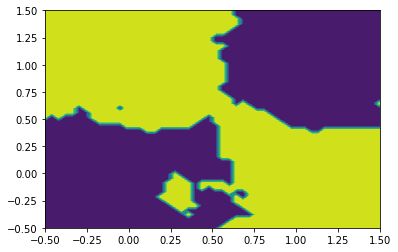

In [116]:
for k in [1, 3, 5]:
    draw_knn_contour(k=k)

## Parzen Window Classifier

In [81]:
def gaussian(x1, x2, variance):
    return np.exp(-(np.linalg.norm(x1 - x2)**2) / (2 * variance))

In [119]:
def classify_parzen_window(x, variance, X=X, y=y):
    distances = np.array([gaussian(x, x2, variance) for x2 in X.T])
    Z = np.sum(distances)
    y_pred = (1 / Z) * np.sum(y * distances)
    return y_pred

In [120]:
classify_parzen_window((0.5, 0.5), 0.1)

0.3904383347332841

In [121]:
def draw_parzen_window_contour(variance, X=X, y=y):    
    xs = np.linspace(-0.5, 1.5)
    ys = np.linspace(-0.5, 1.5)

    z = []
    for i in range(len(xs)):
        for j in range(len(ys)):
            z.append(classify_parzen_window((xs[i], ys[j]), variance, X=X, y=y))

    z = np.array(z).reshape((len(xs), len(ys)))
    zs = (z <= 0.5).astype(int)
    fig, ax = plt.subplots()

    ax.contourf(xs, ys, zs)

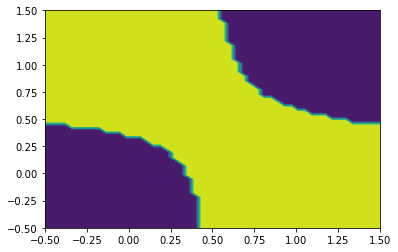

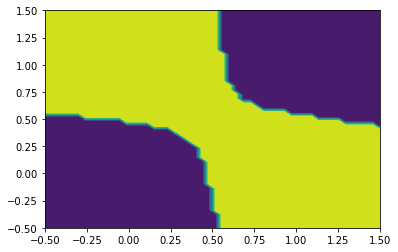

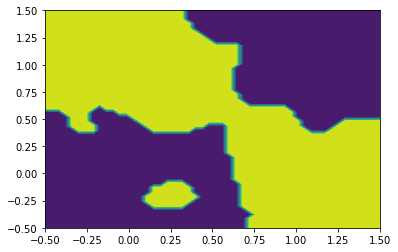

In [117]:
for variance in [0.5, 0.1, 0.01]:
    draw_parzen_window_contour(variance=variance)

### Add third class

In [126]:
X3 = np.random.normal((0.5, 0.5), np.sqrt(0.05), (60, 2)).T
y3 = np.full(60, 2)

In [127]:
X_new = np.hstack([X, X3])
y_new = np.hstack([y, y3])

Should use one-hot encoding for this

## RBF-Network

In [173]:
from sklearn.cluster import KMeans

def phi(x, T, variance):
    distances = np.array([gaussian(x, t, variance) for t in T.T])
    return np.array([1, *distances])

def train_rbf_network(k, variance, X=X, y=y, T=None):
    if T is None:
        kmeans = KMeans(n_clusters=k).fit(X.T)
        T = kmeans.cluster_centers_.T
    Phi = np.apply_along_axis(phi, 1, X.T, T=T, variance=variance).T
    w = np.linalg.inv(Phi @ Phi.T) @ Phi @ y
    return w, T

In [174]:
w, T = train_rbf_network(k=5, variance=0.1)

In [175]:
def classify_rbf(x, w, T, variance):
    return (w.T @ phi(x, T, variance) >= 0.5).astype(int)

In [176]:
classify_rbf((0.5, 0.5), w, T, 0.1)

0

In [177]:
def draw_rbf_contour(k, variance, X=X, y=y):    
    xs = np.linspace(-0.5, 1.5)
    ys = np.linspace(-0.5, 1.5)

    w, T = train_rbf_network(k=k, variance=variance, X=X, y=y)
    
    z = []
    for i in range(len(xs)):
        for j in range(len(ys)):
            z.append(classify_rbf((xs[i], ys[j]), w, T, variance))

    z = np.array(z).reshape((len(xs), len(ys)))
    zs = (z <= 0.5).astype(int)
    fig, ax = plt.subplots()

    ax.contourf(xs, ys, zs)

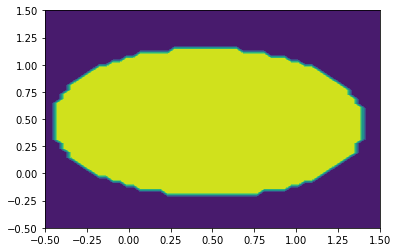

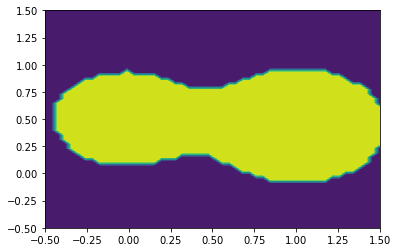

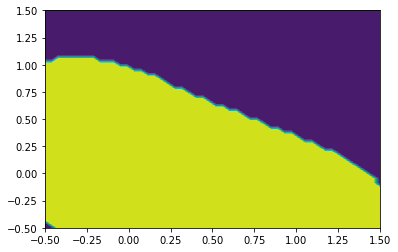

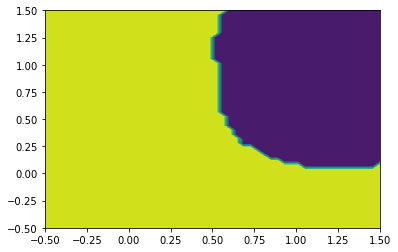

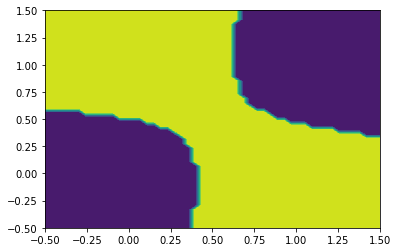

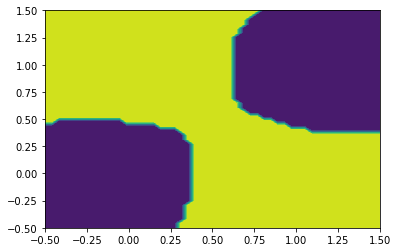

In [178]:
for k in [2, 3, 4]:
    for variance in [0.5, 0.1]:
        draw_rbf_contour(k=k, variance=variance)

### Visualizing Transformed Feature Space

In [187]:
T = np.array([[0,1], [0,1]])

In [188]:
w, T = train_rbf_network(k=2, variance=0.45, T=T)

In [192]:
Phi = np.apply_along_axis(phi, 1, X.T, T=T, variance=0.2).T

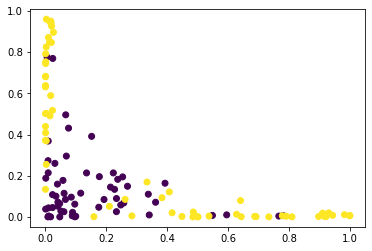

In [193]:
fig, ax = plt.subplots()

ax.scatter(x=Phi[1], y=Phi[2], c=y)

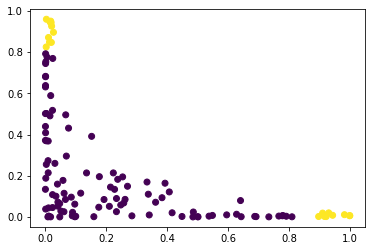

In [194]:
y_pred = [classify_rbf(x, w, T, 0.2) for x in X.T]

fig, ax = plt.subplots()

ax.scatter(x=Phi[1], y=Phi[2], c=y_pred)

The points in (0, 0) and (1, 1) score high in exactly one of the RBF whereas the other points have a mixture of both. The feature space is then non-linearly separable.